### Resources:
* https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html
* https://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/

In [1]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import time

# Sequential Backward Selection
class SBS:
    def __init__(self, estimator, k_features, scoring=accuracy_score, test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]
        
        while dim > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train,  X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
             
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        
        return self
        
    def transform(self, X):
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        
        return score

In [2]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df_wine = pd.read_csv("../data/wine.csv")
df_wine.columns =  ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']
X = df_wine.iloc[:, 1:].values
y = df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

sc = StandardScaler()

X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)


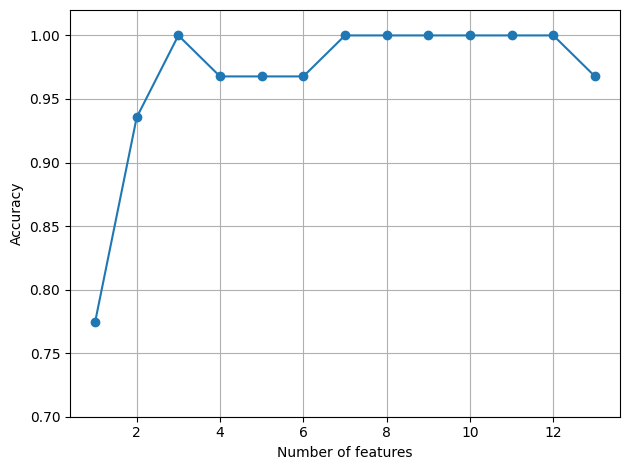

In [3]:
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

In [4]:
k3 = list(sbs.subsets_[10])
print(df_wine.columns[1:][k3])

Index(['Alcohol', 'Malic acid', 'OD280/OD315 of diluted wines'], dtype='object')


In [6]:
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy: 0.967741935483871
Test accuracy: 0.9629629629629629


In [7]:
knn.fit(X_train_std[:, k3], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k3], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k3], y_test))

Training accuracy: 0.9516129032258065
Test accuracy: 0.9259259259259259


 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Proanthocyanins                0.025570
11) Alcalinity of ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279


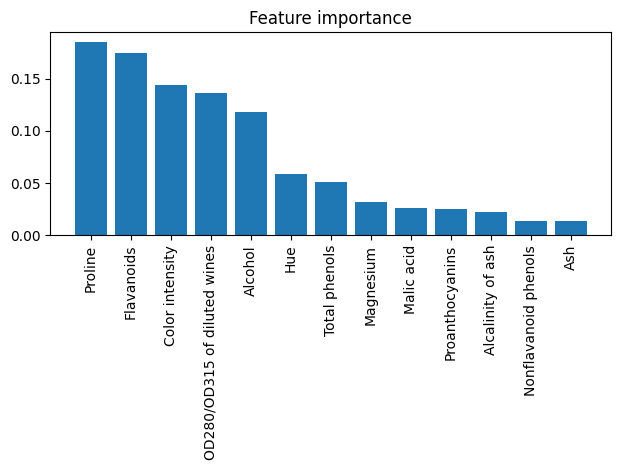

In [ ]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]
forest = RandomForestClassifier(n_estimators=500, random_state=1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))
    
plt.title('Feature importance')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [11]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train)
print('Number of features that meet this threshold', 'criterion:', X_selected.shape[1])
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

Number of features that meet this threshold criterion: 5
 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
